In [1]:
import torch

from dataloader_VOC import data_loaders
from model_unet import Unet

In [2]:
DEVICE = "cuda:0"
device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
model = Unet()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
def l2_loss(x, y, d, back_weight):
    background = ((x[:, 0] - y[:, 0])**2).sum()
    classes = ((x[:, 1:] - y[:, 1:])**2).sum()
    out = background * back_weight + classes
    return classes

def bce_loss(x, y, d):
    bce_loss =  torch.nn.BCELoss()
    return bce_loss(x, y)

def dice_loss(x, y, d, smooth = 1.):
    
    intersection = (x * y).sum(dim=2).sum(dim=2)
    x_sum = x.sum(dim=2).sum(dim=2)
    y_sum = y.sum(dim=2).sum(dim=2)
    dice_loss = 1 - ((2*intersection + smooth) / (x_sum + y_sum + smooth))
    #print(dice_loss.mean().item())
    return dice_loss.mean()

def dice_combo_loss(x, y, d, bce_weight=0.5):
    dice_combo_loss = bce_weight * bce_loss(x, y, d) + (1 - bce_weight) * dice_loss(x, y, d)
    return dice_combo_loss

def l2_combo_loss(x, y, d):
    l2_combo_loss = l2_loss(x, y, d) * bce_loss(x, y, d)
    return l2_combo_loss

In [8]:
def train(num_epochs, back_weight):
    iter = 0
    for epoch in range(num_epochs):
        print('*'*10, 'epoch: ', epoch, '*'*10)
        for phase in ['train', 'valid']:
            #####train_data####
            if phase == 'train':
                for i, data in enumerate(data_loaders[phase]):
                    input, label, depth = data
                    input, label, depth = input.to(device), label.to(device), depth.to(device)
                    output = model(input)
                    
                    loss = bce_loss(output, label, depth)
                    
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                    
                    if iter % 10 == 0:
                        print('iter: ', iter, 'loss_train: ', loss.mean().item())
                    iter +=1
            #####valid_data####
            elif phase == 'valid':
                for i, data in enumerate(data_loaders[phase]):
                    input, label, depth = data
                    input, label, depth = input.to(device), label.to(device), depth.to(device)
                    output = model(input)
                    
                    loss = bce_loss(output, label, depth)
                    
                    if iter % 10 == 0:
                        print('iter: ', iter, 'loss_valid: ', loss.mean().item())
                    iter +=1
        torch.save(model.state_dict(), 'weights.pth')
        print('WEIGHTS IS SAVED: weights.pth')

In [12]:
model.load_state_dict(torch.load('weights.pth'))

<All keys matched successfully>

In [9]:
train(num_epochs=100, back_weight=0.01)

********** epoch:  0 **********


RuntimeError: reduce failed to synchronize: device-side assert triggered

In [7]:
import torchvision
import torchvision.transforms as transforms

import dataloader_VOC

to_pil = transforms.ToPILImage()

In [8]:
data = dataloader_VOC.TrainVOC2012Data()
x, y, z = data[0]
x, y, z = x.to(device), y.to(device), z.to(device)

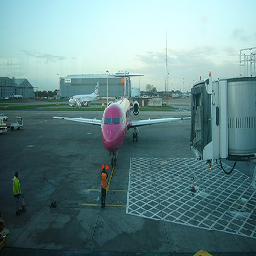

In [9]:
out = model(x.unsqueeze(0)).cpu()
out.shape
to_pil(x.cpu())

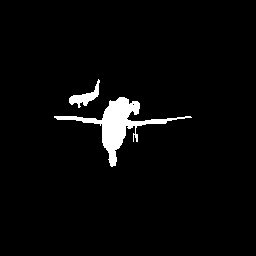

In [14]:
to_pil(y[1].cpu())

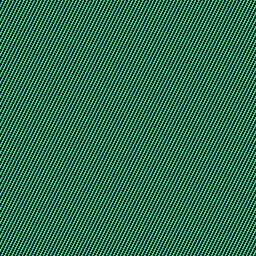

In [60]:
to_pil(out[0])

In [36]:
out[0][0][120]


tensor([3.2993e-21, 7.4957e-16, 1.3823e-17, 1.0193e-18, 1.3393e-17, 6.9920e-17,
        1.7930e-16, 1.6120e-16, 9.3266e-17, 4.1373e-17, 8.9068e-18, 5.0670e-19,
        1.5057e-19, 1.0180e-18, 2.3679e-19, 2.8771e-19, 2.9823e-18, 9.7077e-17,
        1.7791e-15, 4.8836e-15, 3.9404e-15, 1.0605e-15, 5.5066e-16, 5.0970e-16,
        8.9002e-16, 1.5419e-15, 1.3245e-15, 5.3044e-16, 4.5882e-16, 6.5733e-16,
        1.0458e-15, 1.2979e-15, 1.3393e-15, 1.0484e-15, 8.5743e-16, 2.0263e-15,
        3.2207e-15, 2.5540e-15, 1.3933e-15, 1.9576e-15, 3.3878e-15, 9.5580e-16,
        7.0916e-16, 1.3936e-15, 1.3546e-15, 6.5330e-16, 2.4377e-16, 1.7774e-16,
        1.4770e-16, 1.4313e-16, 1.0386e-16, 8.7568e-17, 7.6043e-17, 7.7146e-17,
        7.6662e-17, 7.9594e-17, 7.9704e-17, 7.7959e-17, 7.5917e-17, 7.1579e-17,
        7.0672e-17, 6.8573e-17, 8.3119e-17, 1.0893e-16, 1.6814e-16, 2.2801e-16,
        3.0420e-16, 3.4693e-16, 3.8182e-16, 3.8480e-16, 3.7038e-16, 3.1944e-16,
        2.4705e-16, 1.8943e-16, 1.3981e-

In [47]:
y[0][120]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [74]:
y.shape

torch.Size([21, 256, 256])